In [2]:
import pandas as pd
import numpy as np

In [3]:
def initialize_spin_lattice(N):
    #just combined the creation of the lattice with the relationship between each electron and its
    #neighbors. It actually cut down on hte run time. Found something like this in the same quantum textbook mentioned further down, 
    initial_spins_la = -pd.DataFrame(np.ones((N, N)))
    
    initial_spins_melted = pd.melt(initial_spins_la.reset_index(level=0),id_vars=["index"])
    initial_spins_melted.columns = ["X","Y","spin"]
    initial_spins_melted.reset_index(inplace=True)
    initial_spins_melted.set_index(["X", "Y"],inplace=True)
    
    initial_spins_melted["right_spin"] = initial_spins_melted.groupby('Y')["index"].shift(-1)
    initial_spins_melted["left_spin"] = initial_spins_melted.groupby('Y')["index"].shift(1)
    initial_spins_melted["up_spin"] = initial_spins_melted.groupby('X')["index"].shift(1)
    initial_spins_melted["down_spin"] = initial_spins_melted.groupby('X')["index"].shift(-1)
    
    initial_spins_melted.sort_index(inplace=True)
    
    initial_spins_melted.loc[(0),"left_spin"] = np.array(initial_spins_melted["index"][N-1])
    initial_spins_melted.loc[(N-1),"right_spin"] = np.array(initial_spins_melted["index"][0])
    initial_spins_melted.loc[(slice(None),0),"up_spin"]  = np.array(initial_spins_melted["index"][:,N-1])
    initial_spins_melted.loc[(slice(None),N-1),"down_spin"] = np.array(initial_spins_melted["index"][:,0])
    
    initial_spins_melted["right_spin"]= initial_spins_melted["right_spin"].astype(int)
    initial_spins_melted["left_spin"] = initial_spins_melted["left_spin"].astype(int)
    initial_spins_melted["up_spin"]   = initial_spins_melted["up_spin"].astype(int)
    initial_spins_melted["down_spin"] = initial_spins_melted["down_spin"].astype(int)

    initial_spins_melted.reset_index(inplace=True)
    initial_spins_melted.set_index("index", inplace=True)
    
    return initial_spins_melted

In [4]:
def deltaE(s,sum_j,h,J):#Used to determine if the spins will flip or not
    return 2*s*(J*sum_j + h)


In [5]:
def flip(delta,T,k=1):#What does the flipping
    delta = np.asarray(delta)
    return np.where(np.exp(-delta/(k*T)) > np.random.uniform(),-1,1)

In [6]:
def one_step(la,T,parityX,parityY,h=0,frac=0.7,):
    
    sample_spins = la.loc[(la["X"] % 2 == parityX) & (la["Y"] % 2 == parityY)]#Took a week to figure this out.
    #coudnt get the predicted answers until I found something similar in a code for a quantum machanics question from my old textbook.
    sample_spins = sample_spins.sample(frac=frac)  
    
    #The neighbors of each the electron are considred in this function.
    sum_j = (la.loc[sample_spins["up_spin"], "spin"].values+
            la.loc[sample_spins["down_spin"], "spin"].values+
            la.loc[sample_spins["left_spin"], "spin"].values+
            la.loc[sample_spins["right_spin"], "spin"].values)

    s_i = sample_spins["spin"]

    delta_E = deltaE(s_i,sum_j,h=h,J=1)
    
    #Where the flips actually happen
    
    flip_array = flip(delta_E,T)
    
    la.loc[sample_spins.index, "spin"] *= flip_array
    

In [7]:
#The overarching code responsible for the lattice as a whole
def get_to_equilibrium(la,T,h,frac=0.8,iteration=500):
    for i in range(iteration): 
        parity = np.random.choice([0,1], size=2)
        one_step(la, T, parity[0], parity[1], h, frac)

In [8]:
#getting the magnetization is easy, while the energy requires mroe work to calculate.
def compute_energy(la):
    tot = 0
    for i in la.index:
        
        tot = tot + 0.5 * -1 * la["spin"].loc[i]*(la["spin"].loc[la["right_spin"].loc[i]]+
                                                        la["spin"].loc[la["left_spin"].loc[i]]+
                                                        la["spin"].loc[la["up_spin"].loc[i]]+
                                                        la["spin"].loc[la["down_spin"].loc[i]])
    return tot/len(la)

In [11]:
#arrays need to be made for the magnetic field values, both ascending and descending
h_forward = np.arange(-5, 5, 0.3)
h_backward = np.arange(5, -5, -0.3)
#Easy to calcula
def compute_magnetization(x):
    return x.mean()
#The ferromagnet is constructed here.
spin_lattice = initialize_spin_lattice(32)  

# hold equilibirum spins for each h
h_forward_la = pd.DataFrame(index=spin_lattice.index, columns=h_forward) 


for i in h_forward:                                         # iterate through the h values
    get_to_equilibrium(la = spin_lattice, T = 3, h = i)     # get to equilibrium
    
    h_forward_[i] = spin_lattice["spin"]
    
# store magnetization values
hf_mag = pd.DataFrame(columns=["Magnetization"],index=h_forward)         

# compute magnetization for each h value
hf_mag["Magnetization"] = h_forward_la.apply(compute_magnetization)
## initialize spin lattice
spin_lattice = initialize_spin_lattice(32)    

# create hold equilibirum spins for each h
h_backward_la = pd.DataFrame(index=spin_lattice.index, columns=h_backward)

for i in h_backward:                                       
    get_to_equilibrium(la = spin_lattice, T = 3, h = i)    
    
    h_backward_la[i] = spin_lattice["spin"]
    
#store magnetization values   
hb_mag = pd.DataFrame(columns=["Magnetization"],index=h_backward)           

## compute magnetization for each h value
hb_mag["Magnetization"] = h_backward_la.apply(compute_magnetization)

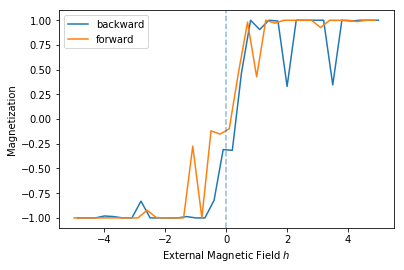

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hb_mag.index,hb_mag["Magnetization"],label="backward")
plt.plot(hf_mag.index,hf_mag["Magnetization"],label="forward")
plt.xlabel("External Magnetic Field $h$")
plt.ylabel("Magnetization")
plt.axvline(linestyle='--',alpha=0.1)
plt.legend()
plt.show()